# Text Analysis with 10-K Business Descriptions from Edgar
- part-of-speech tag, lemmatize, named entity recognition
- jaccard similarity, cosine similarity, multilevel community detection
- spacy, nltk, sklearn, igraph
- Hoberg and Phillips (2016), SEC Edgar, Wharton Research Data Services

Terence Lim
License: MIT

In [1]:
import re
import os
import time
import gzip, json
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import seaborn as sns
import igraph  # pip3 install cairocffi
from igraph import Graph
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from tqdm import tqdm
from collections import Counter
from finds.database import SQL, MongoDB, Redis
from finds.structured import CRSP, PSTAT
from finds.busday import BusDay, int2date
from finds.unstructured import Unstructured
from finds.edgar import EdgarClone, Edgar
from finds.graph import igraph_info, igraph_community
from finds.sectors import Sectoring
from settings import settings
ECHO = False
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
bd = BusDay(sql)
rdb = Redis(**settings['redis'])
crsp = CRSP(sql, bd, rdb)
mongodb = MongoDB(**settings['mongodb'])
wordlists = Unstructured(mongodb, 'WordLists')
ed = EdgarClone(settings['10X'], zipped=True, echo=ECHO)
imgdir = os.path.join(settings['images'], 'edgar')
item, form = 'bus10K', '10-K'

# Retrieve business description (10-K item 1) from Edgar


In [2]:
from nltk.tokenize import RegexpTokenizer
ticker = 'AAPL'
cik = Edgar.fetch_tickers()[ticker.lower()]                 # lookup aapl's cik
stop_words = [w for c in ['genericlong', 'DatesandNumbers'] # LM stop word lists
              for w in wordlists['lm', c.lower()]] # if "'" not in w]
top_words = {}
for year in [2003, 2020]:
    files = Edgar.fetch_index(year=year, quarter=4)  # 
    r = files[files['cik'].eq(cik) & files['form'].isin(Edgar.forms_['10-K'])]
    htmls = Edgar.extract_filenames(Edgar.fetch_detail(r.iloc[0]['pathname']))
    filing = Edgar.fetch_filing(Edgar.from_path(r.iloc[0]['pathname'],htmls[0]))
    doc = Edgar.extract_item(filing, 'bus10K')
    print(ticker, year, 'business description:')
    print(doc[:500])
    words = doc.lower()
    tokenizer = RegexpTokenizer(r"\b[^\d\W][^\d\W][^\d\W]+\b")
    unigrams = [t for t in tokenizer.tokenize(words) if t not in stop_words]
    counts = Series(unigrams).value_counts()
    unigrams = [t for t in unigrams if t not in counts[counts > 40].index]
    unigram_counts = Series(unigrams).value_counts()
    bigrams = [a + '_' + b for a,b in zip(unigrams[:-1], unigrams[1:])]
    bigram_counts = Series(bigrams).value_counts()
    top_n = 20
    top_words[year] = bigram_counts.iloc[:top_n].to_dict()
DataFrame(top_words).fillna(0).astype(int)

AAPL 2003 business description:
ITEM 1. BUSINESS

COMPANY BACKGROUND

APPLE COMPUTER, INC. ("APPLE" OR THE "COMPANY") WAS INCORPORATED UNDER THE LAWS OF THE STATE OF CALIFORNIA ON JANUARY 3, 1977. THE COMPANY DESIGNS, MANUFACTURES

AND MARKETS PERSONAL COMPUTERS AND RELATED SOFTWARE, PERIPHERALS AND PERSONAL COMPUTING AND COMMUNICATING SOLUTIONS. THE COMPANY'S PRODUCTS INCLUDE THE MACINTOSH® LINE OF DESKTOP AND

NOTEBOOK COMPUTERS, THE MAC OS® X OPERATING SYSTEM, THE IPOD DIGITAL MUSIC PLAYER, AND A PORTFOLIO OF SOFTWARE AND 
AAPL 2020 business description:
ITEM 1.    BUSINESS

COMPANY BACKGROUND

THE COMPANY DESIGNS, MANUFACTURES AND MARKETS SMARTPHONES, PERSONAL COMPUTERS, TABLETS, WEARABLES AND ACCESSORIES, AND SELLS A VARIETY OF RELATED SERVICES. THE COMPANY’S FISCAL YEAR IS THE 52- OR 53-WEEK PERIOD THAT ENDS ON THE LAST SATURDAY OF SEPTEMBER. THE COMPANY IS A CALIFORNIA CORPORATION ESTABLISHED IN 1977.

PRODUCTS

IPHONE

IPHONE

®

IS THE COMPANY’S LINE OF SMARTPHONES BASED ON I

,2003,2020
itunes_store,16,0
final_cut,11,0
macintosh_systems,10,0
personal_computers,10,5
operating_system,9,5
high_quality,9,0
personal_computer,9,0
airport_extreme,8,0
education_customers,8,0
united_states,8,0


# Display top words

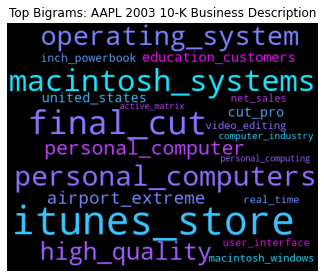

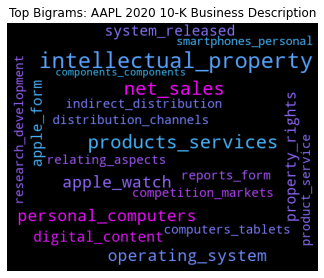

In [3]:
for num, (year, words) in enumerate(top_words.items()):
    wc = WordCloud(height=400, width=500,  colormap='cool')
    fig, ax = plt.subplots(1, 1, num=num+1, clear=True, figsize=(5,4))
    ax.imshow(wc.generate_from_frequencies(words))
    ax.axis("off")
    plt.tight_layout(pad=2)
    ax.set_title(f"Top Bigrams: {ticker} {year} 10-K Business Description")
    #plt.savefig(os.path.join(imgdir, f"{ticker}{year}.jpg"))
plt.show()

# Community Detection with Business Descriptions

In [4]:
# Load spacy vocab
lang = 'en_core_web_lg'
nlp = spacy.load(lang, disable=['ner'])
n_vocab, vocab_dim = nlp.vocab.vectors.shape
print('Language:', lang, '   vocab:', n_vocab, '   dim:', vocab_dim)
stopwords = {'company', 'companys', 'companies', 'product', 'products',
             'service', 'services', 'business', 'description', 'year', 'years'}

# Load stock universes
univs = {y: crsp.get_universe(bd.endmo(int(f"{y-1}1231"))).assign(year=y)
         for y in range(1993, 2021)}

Language: en_core_web_lg    vocab: 684830    dim: 300


## Extract lemmatized nouns from bus10K documents


In [ ]:
A = ed.open(form=form, item=item)  # open bus10K archive
A['year'] = [d.year-(d.month<4) for d in int2date(A['date'])] # set fiscal year

tic = time.time()
for year in [2018, 2017]: #[2020, 2019, 2018, 2017]:
    docs = dict()
    for i, permno in tqdm(enumerate(sorted(univs[year].index))):
        doc = A[A['permno'].eq(permno) & A['year'].eq(year)].sort_values('date')
        if len(doc):
            text = ed[doc.iloc[0]['pathname']].encode('ascii', 'ignore').lower()
            tokens = nlp(text.decode()[:900000])
            nouns = [t.lemma_ for t in tokens if t.pos_ in ['NOUN','PROPN'] and
                     len(t.text)>1 and not (t.is_oov or t.is_stop) and
                     t.text not in stopwords]
            counts = Series(nouns, dtype='object').value_counts()
            if len(counts):
                docs[permno] = counts.to_dict()
    print(year, len(docs), f"{time.time()-tic:.1f}")
    with gzip.open(os.path.join(imgdir, f"docs{year}.json.gz"), 'wt') as f:
        json.dump(docs, f)     # save this year's docs


## Text Vectorizer

In [6]:
max_df, min_df, max_features = 0.5, 25, 10000
#max_df, min_df, max_features = 1.0, 1, None
tv = text.TfidfVectorizer(max_df=max_df,min_df=min_df,max_features=max_features)
cv = text.CountVectorizer(max_df=max_df,min_df=min_df,max_features=max_features)

# Helper to return an iterable of str from dict of docs dicts
def iterable(docs, unique=True, key=False, lemma=False):
    for k, doc in docs.items():
        value = " ".join([k if unique else " ".join([k] * v)
                          for k,v in doc.items()])
        if lemma:
            value = " ".join(t.lemma_ for t in nlp(value))
        yield (k, value) if key else value

## Document term frequencies and average word vectors, and cosine and jaccard similiary


In [7]:
similar = dict()
for year in [2020]:#, 2019, 2018]:
    similar[year] = dict()
    with gzip.open(os.path.join(imgdir, f"docs{year}.json.gz"), 'rt') as f:
        docs = json.load(f)

    # document term frequencies and average word vectors
    tic = time.time()
    x = cv.fit_transform(iterable(docs, unique=True)) # term dummy
    feature_names = cv.get_feature_names()
    df = Series({k: v for k,v in zip(feature_names,
                                     np.asarray(np.sum(x, axis=0)).flatten())})
    tfidf = tv.fit_transform(iterable(docs, unique=False)) # tfidf
    vector = np.zeros((len(docs), vocab_dim))
    permnos = []
    for i, (key, doc) in tqdm(enumerate(iterable(docs, unique=False, key=True))):
        permnos.append(int(key))
        vector[i] = nlp(doc).vector
    print(time.time() - tic)

    # compute cosine similarity matrixes between documents
    similar[year]['cosine'] = cosine_similarity(tfidf, tfidf)
    #cos_vector[year] = cosine_similarity(vector, vector) 
    #corr_tfidf[year] = np.corrcoef(tfidf.toarray(), rowvar=True)
    terms = (tfidf > 0).todense()
    similar[year]['jaccard'] = 1- pairwise_distances(terms,metric="jaccard")

3219it [26:22,  2.03it/s]


1592.6109266281128


## Populate new DataFrame, indexed by permnos, with sic and naics codes


In [8]:
pstat = PSTAT(sql, bd)
vs = DataFrame(index=permnos)
for code in ['sic', 'naics']:
    lookup = pstat.build_lookup('lpermno', code, fillna=0)
    vs[code] = lookup(vs.index)
naics = Sectoring(sql, 'naics', fillna=0)   # supplement from crosswalk
sic = Sectoring(sql, 'sic', fillna=0)
vs['naics'] = vs['naics'].where(vs['naics'] > 0, naics[vs['sic']])
vs['sic'] = vs['sic'].where(vs['sic'] > 0, naics[vs['naics']])
Series(np.sum(vs > 0, axis=0)).rename('Non-missing').to_frame().T


,sic,naics
Non-missing,3219,3219


## Use sectoring scheme

In [9]:
scheme = 'codes49'
codes = {scheme: Sectoring(sql, scheme, fillna=0)}
vs[scheme] = codes[scheme][vs['sic']]
vs = vs[vs[scheme].ne(codes[scheme].fillna)]
vs


,sic,naics,codes49
10026,2050,311812,Food
10028,5990,453998,Rtail
10032,3672,334412,Chips
10044,2060,311352,Food
10051,8093,621498,Hlth
...,...,...,...
93422,1311,2111,Oil
93423,7996,713110,Fun
93426,3674,334413,Chips
93434,100,111998,Agric


## Run community detection on edges 


Min jaccard similarity threshold for edges: 40th %-tile
Deleting 6 vertex IDs with degree 0.

     vertices    edges   density simple directed weak-components largest-weak
2020     3213  3106737  0.602072   True    False               2         3198
                     modularity  components
jaccard threshold %                        
40                     0.075417           5
  Community 1: Banks(359), Oil(89), Insur(86)
  Community 2: Softw(125), Chips(111), Mach(69)
  Community 3: Drugs(459), Softw(107), MedEq(102)
  Community 4: Banks(22), Steel(3), Softw(2)
  Community 5: Other(3), Rtail(2), Drugs(2)

Min jaccard similarity threshold for edges: 60th %-tile
Deleting 12 vertex IDs with degree 0.

     vertices    edges   density simple directed weak-components largest-weak
2020     3207  2070202  0.402699   True    False               3         3140
                     modularity  components
jaccard threshold %                        
60                     0.130905           5


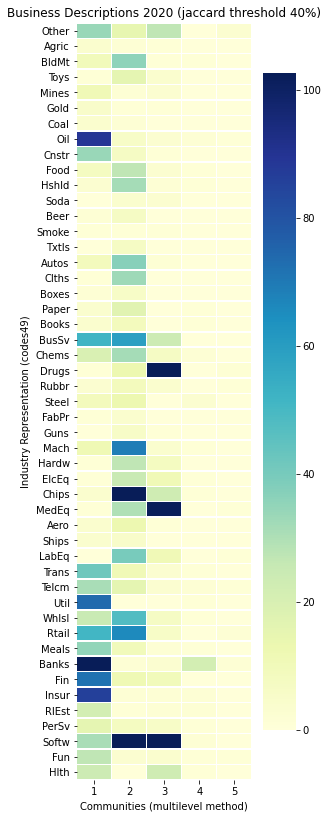

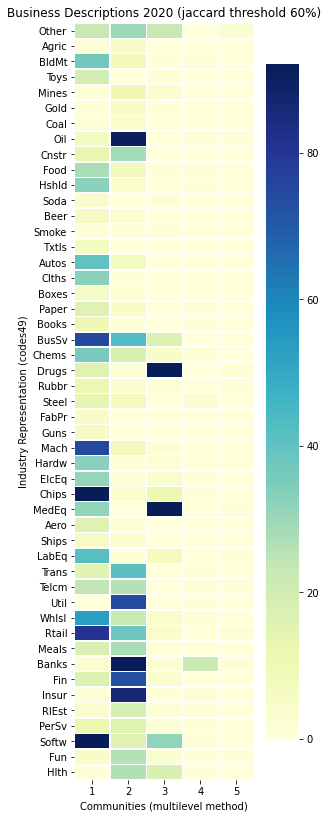

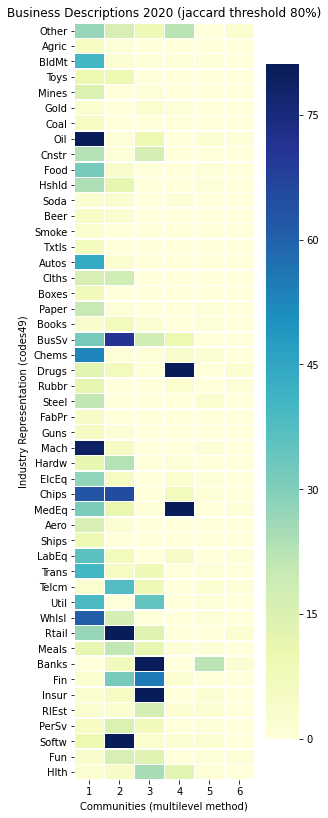

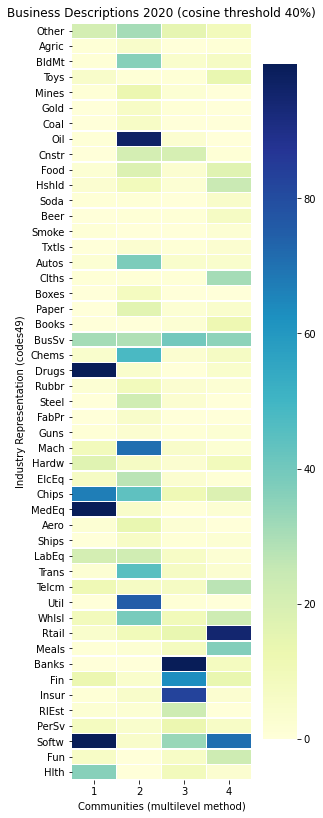

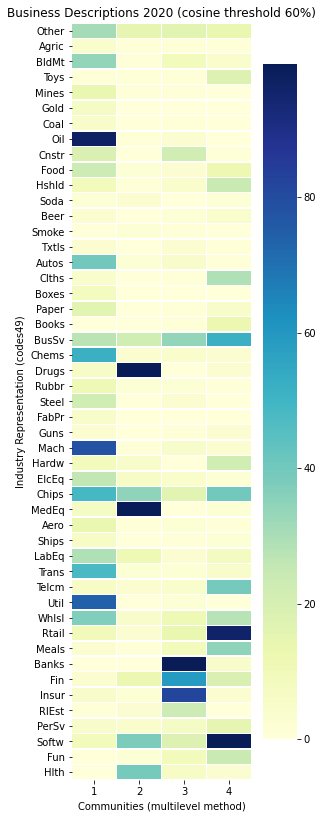

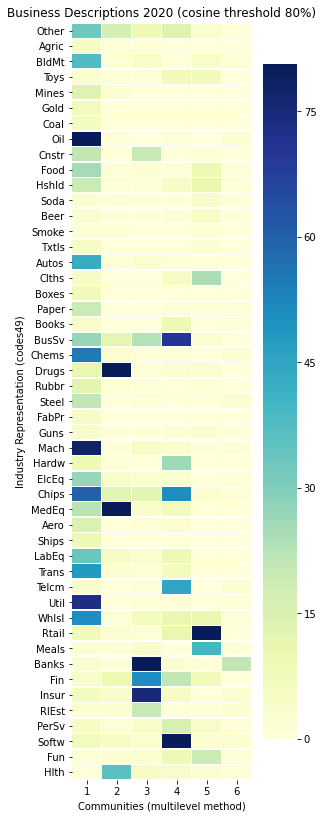

In [11]:
for num, metric in enumerate(['jaccard', 'cosine']):
    
    # Create edges, and edge value thresholds
    perms = [str(p) for p in permnos]
    E = DataFrame(data=similar[year][metric], index=perms, columns=perms)
    E = E.stack()
    thresh = [10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95]
    thresh = {t: v for t,v in zip(thresh, np.percentile(E, thresh))}
    E = E.reset_index()

    thresholds = [40, 60, 80]
    for i, pct in enumerate(thresholds):  # percentile thresholds to cull edges
        print(f'\nMin {metric} similarity threshold for edges: {pct}th %-tile')
        edges = E[(E.iloc[:,0] != E.iloc[:,1]) & (E.iloc[:,-1] > thresh[pct])]
        attributes = edges.iloc[:, -1].values
        edges = edges.iloc[:, :-1].values
        
        # Populate igraph including attributes (note: vertex names must be str)
        g = Graph(directed=False)
        g.add_vertices(vs.index.astype(str).to_list(), vs.to_dict(orient='list'))
        g.add_edges(edges, {'score': attributes})
        degree = Series(g.vs.degree())   # to remove zero degree vertexes
        print('Deleting', len(degree[degree==0]), 'vertex IDs with degree 0.\n')
        g.delete_vertices(degree[degree==0].index.to_list())
        g = g.simplify()         # remove self-loops and multi-edges
        s = Series(igraph_info(g, fast=True)).rename(year)
        print(s.to_frame().T)
        #t = g.components(mode=1)
        #print('Deleting', t._len-1, 'components with sizes', t.sizes()[1:], '\n')
        #g = t.subgraph(0)
        
        # detect communities and report modularity
        c = g.community_multilevel()
        print(DataFrame({'modularity':c.modularity, 'components':len(c.sizes())},
                        index=[pct]).rename_axis(f'{metric} threshold %'))
        
        # plot and display industry representation of communities detected
        detect = 'multilevel'
        indus = pd.concat([Series(c.subgraph(j).vs[scheme])\
                           .value_counts().rename(i+1)
                           for i, j in enumerate(np.argsort(c.sizes())[::-1])],
                          axis=1).dropna(axis=0, how='all').fillna(0).astype(int)\
                  .reindex(codes[scheme].sectors['name']\
                           .drop_duplicates(keep='first'))
        for j in indus.columns:
            tops = ", ".join(f"{k}({v})" for k,v in
                             indus.sort_values(j)[-1:-4:-1][j].items())
            print(f"  Community {j}:", tops)              
        fig, ax = plt.subplots(num=(len(thresholds)*num) + 1 + i, clear=True,
                               figsize=(5, 12))
        sns.heatmap(indus, square=False, linewidth=.5, ax=ax, yticklabels=1,
                    cmap="YlGnBu", robust=True)
        ax.set_yticklabels(indus.index, size=10)
        ax.set_xlabel(f'Communities ({detect} method)')
        ax.set_ylabel(f'Industry Representation ({scheme})')
        ax.set_title(f"Business Descriptions {year} ({metric} threshold {pct}%)")
        fig.subplots_adjust(left=0.4)
        plt.tight_layout(pad=3)
        plt.savefig(os.path.join(imgdir, f'{metric}{year}_{pct}.jpg'))
plt.show()